In [1]:
using Plots
using ForwardDiff

In [2]:
function sample!(x,θ)
    T = size(θ,2)
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [294]:
function logqt(x,θt,t)
    return log((x[t+1] - x[t]) == 1 ? θt[x[t] + T] : 1 - θt[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2)
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

function isok(x)
    return 3 <= abs(x[end]) <= 6 
end

function logO(x)
    if isok(x)
        @show x
        return 0
    else
        return -10
    end
end

logO (generic function with 1 method)

In [295]:
function gradient!(dθ, x, θ)
    T = size(θ,2)
    for t = 1:T-1
        ForwardDiff.gradient!((@view dθ[:,t]), θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [296]:
function descend!(θ, θp, θmin, θmax; numsamples=10^4, η=0.1)
    N, T = size(θ)
    dθ = zero(θ)
    x = zeros(Int, N)
    
    Dθ = zero(θ)
    avF = 0    
    for s = 1:numsamples
        sample!(x, θ)
        F = logQ(x,θ) - logQ(x,θp) - logO(x)
        avF += F
        gradient!(dθ, x, θ)
        Dθ .+= F .* dθ
    end
    θ .-= sign.(dθ) .* abs.(θ) .* η
    θ .= clamp.(θ, θmin, θmax)
    return avF / numsamples
end

descend! (generic function with 2 methods)

In [388]:
T = 25 #total time of movement
N = 2T - 1

θ = fill(0.5,N,T); 
#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
dθ = fill(1/2,N,T); 

θp = fill(1/2,N,T); 

x = zeros(Int,T);

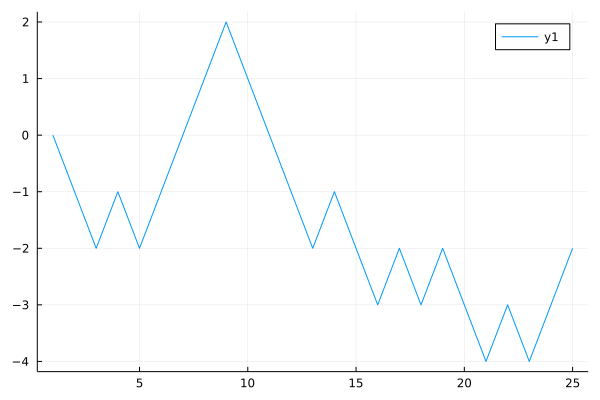

In [389]:
sample!(x,θp)

plot(x)

In [390]:
isok(x)

false

In [472]:
using ProgressMeter
avF = descend!(θ, θp, 1e-4, 1-1e-4; numsamples=1000, η=0.3)

11.022417734251

In [473]:
avF

11.022417734251

In [474]:
θ

49×25 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5   0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.35  0.5  0.5
 ⋮             

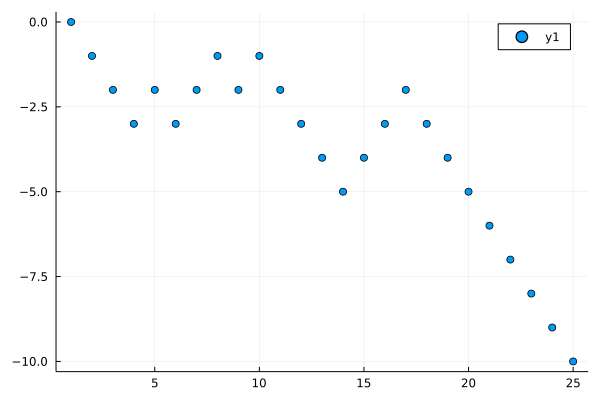

In [476]:
sample!(x,θ)

scatter(x)